# United States Flight Carriers Efficiency

## by Ahmed Mohammed Mohammed



## Investigation overview
In this investigation the main concern was to determine the best Flight carrier compony in US. I wanted to know if there were outstanding carriers and what are the reasons that makes them outstand. 

## Dataset overview
The data set keeps record of the fligths info in the US airports in the period from 2010 to 2019 with 156000 record.

It contains detailed information about the number of flights delayed, time delayed, reasons for delays and the contribution of each reason. 

It also keeps record of the canceled and diverted flights in each month for each airport and carrier.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
flight_df = pd.read_csv('FlightDelaying.csv')
flight_df.drop(columns='Unnamed: 21',inplace =True)
flight_df.columns = flight_df.columns.str.replace(' ', '')


## Remove the null records

In [3]:
flight_df.dropna(inplace=True)
print(flight_df.isnull().sum().sum())
print(flight_df.shape)

0
(165190, 21)


In [4]:
flight_df = flight_df.query('year<2020')

flight_df['human_ct'] = flight_df[['carrier_ct','late_aircraft_ct']].sum(axis=1)
flight_df['human_delay'] = flight_df[['carrier_delay','late_aircraft_delay']].sum(axis=1)

df_carriers = flight_df.groupby(by=['year','month','carrier']).sum().reset_index()

df_carriers['hu_del_per'] = df_carriers['human_delay']/df_carriers['arr_delay']
df_carriers['hu_ctr_per'] = df_carriers['human_ct']/df_carriers['arr_del15']



df_carriers['day'] = 1
k = pd.to_datetime(df_carriers[['year','month','day']])
df_carriers['time_stamp'] = k
df_carriers['time_stamp'] = pd.to_datetime(df_carriers['time_stamp']).astype('str')

In [5]:
cat_means = df_carriers.groupby(['time_stamp', 'carrier']).mean()['arr_flights']
cat_means = cat_means.reset_index(name = 'arr_flights_avg')
cat_means = cat_means.pivot(index = 'carrier', columns = 'time_stamp',
                             values = 'arr_flights_avg')

order = cat_means.sum(axis=1).sort_values(ascending=False).index
cat_means = cat_means.reindex(order)

## Distribution of schedueld flights
The arrived flights in the last 10 years are disributed on 22 US. carriers. Most of the arrived flights are on 5 main carriers.

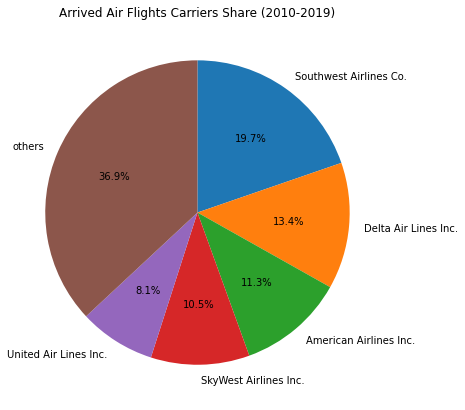

In [6]:
cars = ['WN','DL','AA','OO','UA']


plt.figure(figsize=(7,7))
order = cat_means.sum(axis=1).sort_values(ascending=False)
order['others'] = order[~order.index.isin(cars)].sum()
order = order[(order.index.isin(cars)) | (order.index=='others')]
ks = list(order.index)
ks.pop()
lab=[]

for code in ks:
    lab.append(flight_df.query('carrier == @code').carrier_name.unique()[0])
lab.append('others')  

plt.pie(order,labels =lab, startangle= 90
,counterclock = False, autopct='%1.1f%%');
plt.title('Arrived Air Flights Carriers Share (2010-2019)');

In [7]:
cat_means = df_carriers.query('carrier in @cars')
cat_means = cat_means.groupby(['year', 'carrier']).mean()['arr_flights']
cat_means = cat_means.reset_index(name = 'arr_flights_avg')
cat_means = cat_means.pivot(index = 'carrier', columns = 'year',
                             values = 'arr_flights_avg')

order = cat_means.sum(axis=1).sort_values(ascending=False).index
cat_means = cat_means.reindex(order)
cat_means = cat_means.reset_index()

## Flights arrived for the highest five carriers (2010-2019)
The advancing of the highest five carriers in flights indicates how much each of them is advancing across time.
The Southwest Airlines Co. is the highest carrier with big margin of 0.4 Million arrived flights yearly.

The American Airlines Inc. had a high jump between 2014 and 2016 to be very close to the second position after being in the forth position.

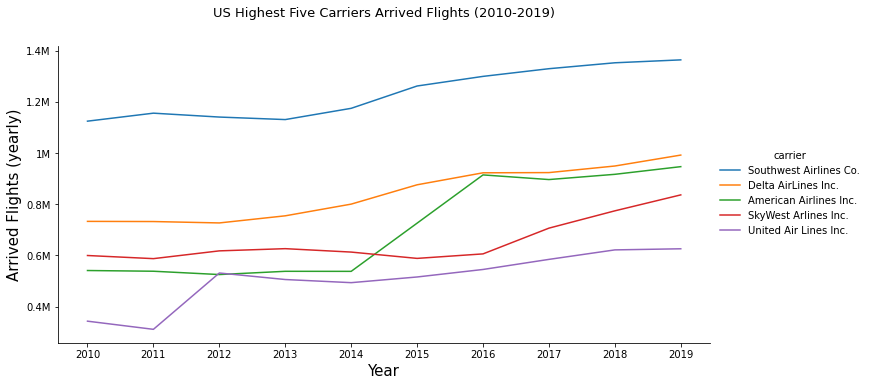

In [8]:
names = ['Southwest Airlines Co.','Delta AirLines Inc.','American Airlines Inc.','SkyWest Arlines Inc.','United Air Lines Inc.']
di = {i:k for i,k in zip(cars,names)}
years = [year for year in range(2010,2020)]
cat_means = cat_means.replace({"carrier": di})
df = df_carriers.groupby(['carrier','year']).agg({'arr_flights':'sum'}).reset_index()
df = df.query('carrier in @cars').replace({"carrier": di})

#df_carriers
g = sb.FacetGrid(data = df, hue = 'carrier',hue_order=names, height = 5,aspect=2);
g.map(plt.errorbar, 'year', "arr_flights");
g.set_ylabels('Arrived Flights (yearly)',fontsize=15);
plt.xlabel('Year',fontsize=15)
g.add_legend();
plt.xticks([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019])
plt.yticks([400000,600000,800000,10**6,1.2*10**6,1.4*10**6],['0.4M','0.6M','0.8M','1M','1.2M','1.4M']);
plt.title('US Highest Five Carriers Arrived Flights (2010-2019)',y=1.08,fontsize=13);

## Carriers  Arrived Flights Handling

The number of arrived flights affects the number of delayed flights due to carrier problems. The relationship is positive for every one of the five carriers except for the Southwest Airlines Co.

The carriers show to have clusters at different ranges of arrived flights.

This may be related with expansions in these carriers at different times to handle the increasing number of arrived flights.

Generally Delta Airlines Inc. and the American Airlines Inc has the highest number of arrived flights with the lowest number of delayed flights due to carrier problems. 

In [9]:
sample = df_carriers.query('carrier in @cars').replace({"carrier": di})


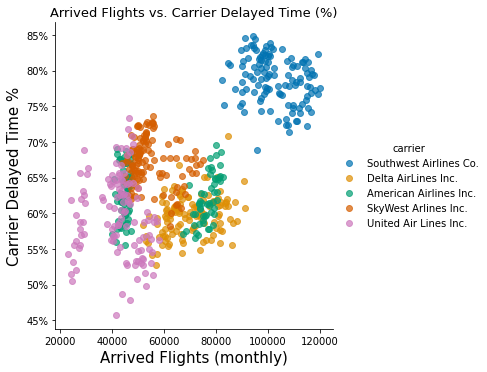

In [10]:
g = sb.FacetGrid(data = sample, hue = 'carrier', height = 5,palette = 'colorblind',hue_order=names)
g.map(plt.scatter, 'arr_flights', 'hu_ctr_per',alpha=7/10);
g.add_legend();
g.set_xlabels('Arrived Flights (monthly)',fontsize=15);
g.set_ylabels('Carrier Delayed Time %',fontsize=15);
plt.title('Arrived Flights vs. Carrier Delayed Time (%)',fontsize=13);
plt.yticks([0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],['45%','50%','55%','60%','65%','70%','75%','80%','85%']);


## Relying On One Airport And Carrier Performance
Relying on one airport for most of arrived airflights has negative relationship with the percentage of time delayed because of the carrier.

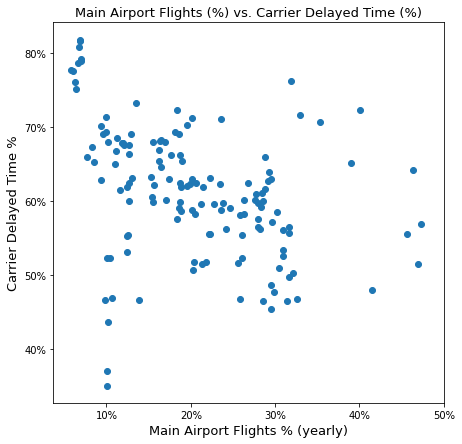

In [11]:
plt.figure(figsize=(7,7));
one_airport_relying = flight_df.groupby(['carrier','year','airport']).agg({'arr_flights': 'sum'}).groupby(level=[0,1]).apply(lambda x:
                                                 100 * x / float(x.sum())).groupby(level=[0,1]).max()
yearly_delation = df_carriers.groupby(['carrier','year']).agg({'hu_ctr_per': 'mean'})
#yearly_delation
one_airport_relying = one_airport_relying.iloc[one_airport_relying.index.get_level_values(0) != 'HA']
yearly_delation = yearly_delation.iloc[yearly_delation.index.get_level_values(0) != 'HA']

plt.scatter(one_airport_relying,yearly_delation)
#one_airport_relying
plt.xticks([10,20,30,40,50],['10%','20%','30%','40%','50%'])
plt.yticks([0.4,0.5,0.6,0.7,0.8],['40%','50%','60%','70%','80%'])

plt.title('Main Airport Flights (%) vs. Carrier Delayed Time (%)', fontsize=13);
plt.xlabel('Main Airport Flights % (yearly)', fontsize=13);
plt.ylabel('Carrier Delayed Time %', fontsize=13);

## The Five First Carriers Stratigy In Using Airports

Each on of the five first carriers has approximate stable stratigy in relying on airports.

This affects the range of carrier contribution to delayed time in delayed flights highly.

In [12]:
def scatter_color(x,y,c,**kwargs):
    
    plt.scatter(x=x,y=y,c = c,cmap = 'inferno_r',vmin=5,vmax=25 )
    plt.title('{columns}')

    

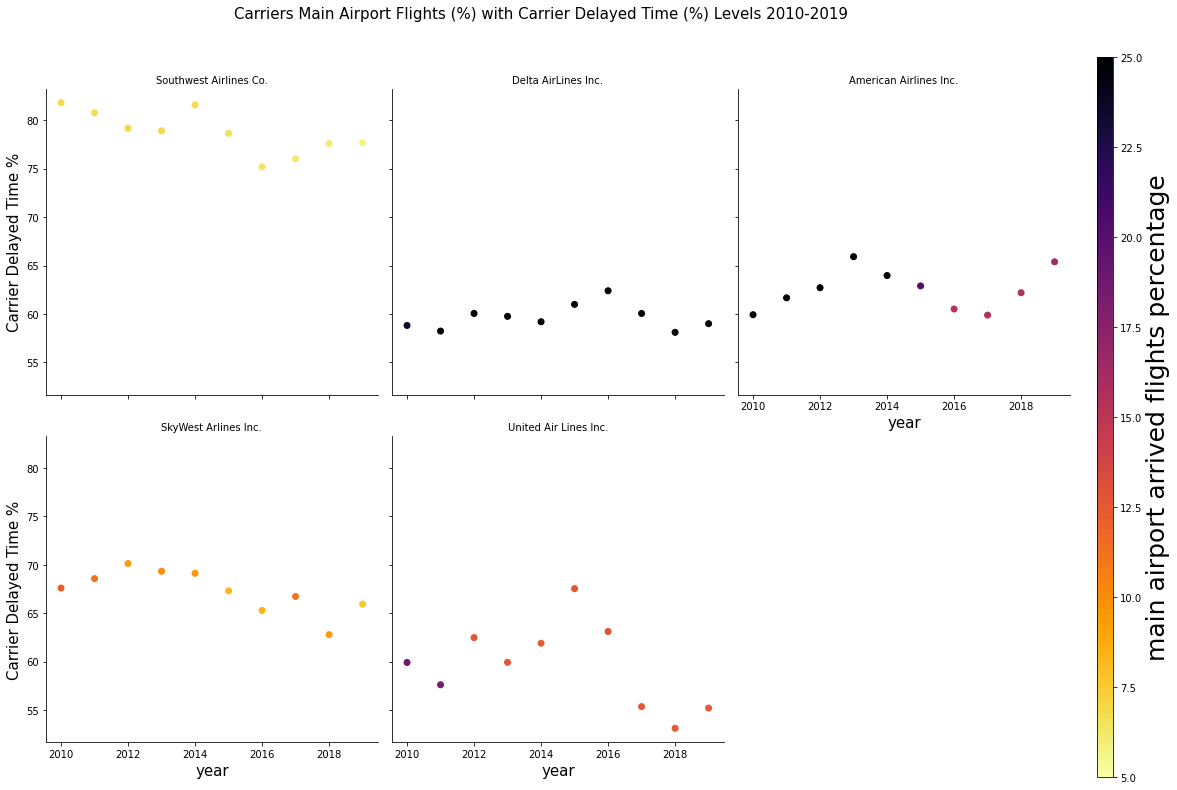

In [47]:
df = one_airport_relying.join(yearly_delation).reset_index().query('carrier in @cars').replace({"carrier": di})
df['hu_ctr_per'] = df['hu_ctr_per']*100
g = sb.FacetGrid(data = df, col = 'carrier',col_order=names, height = 5, col_wrap = 3);
g = g.map(scatter_color,'year',  'hu_ctr_per', 'arr_flights');
cbar_ax = g.fig.add_axes([1.015,0.01, 0.015, 1])



g.axes[0].set_ylabel('Carrier Delayed Time %', fontsize=15);
g.axes[3].set_ylabel('Carrier Delayed Time %', fontsize=15);
g.axes[4].set_xlabel('year', fontsize=15);
g.axes[3].set_xlabel('year', fontsize=15);
g.axes[2].set_xlabel('year', fontsize=15);
cb = plt.colorbar(cax=cbar_ax);

cb.set_label(label='main airport arrived flights percentage',fontsize=25)
g.set_titles('{col_name}');
g.fig.suptitle('Carriers Main Airport Flights (%) with Carrier Delayed Time (%) Levels 2010-2019',y=1.08, fontsize=15);
#g.title('Carriers Main Airport Flights (%) vs. Carrier Delayed Time (%) (2010-2019)');